In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
import sys
sys.path.insert(0, '/projects/b1094/jding/athena/vis/python')
import athena_read

# Disk (spherical)

2/23/26: Checking results for a viscous disk in spherical coordinates. I'm using constant grid spacing, so $\Delta r$, $\Delta \theta$, and $\Delta \phi$ are constants.

In [3]:
num_ghost = 2

time: 0
total mass: 1.3511461013468404
sum over dens: 112007.01839067353
Sigma slope = -0.74

time: 1256
total mass: 12.200012556455011
sum over dens: 973045.5384925905
Sigma slope = -0.61

time: 2198
total mass: 65.88907688496019
sum over dens: 5243378.143867936
Sigma slope = -0.6

time: 3140
total mass: 353.85106282297204
sum over dens: 28190925.766113367
Sigma slope = -0.61



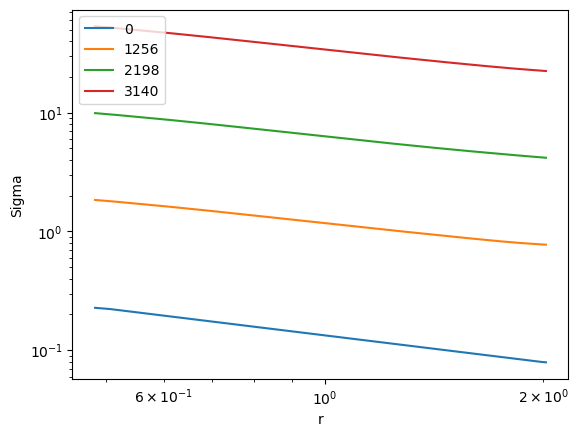

In [27]:
results_dir = "/scratch/phn2956/disk-sph1/"


hdf5_file0 = results_dir + "disk.out1.00000.athdf"
hdf5_file1 = results_dir + "disk.out1.00065.athdf"
hdf5_file2 = results_dir + "disk.out1.00080.athdf"
hdf5_file3 = results_dir + "disk.out1.00095.athdf"
#hdf5_file3 = results_dir + "disk.out1.00100.athdf"
#hdf5_file3 = "/scratch/phn2956/disk-cyl-BCs-only/disk.out1.00010.athdf"

file_list = [hdf5_file0, 
             hdf5_file1,
            hdf5_file2,
             hdf5_file3]

fig = plt.figure()
ax = fig.add_subplot()

for file in file_list:
    ath_data = athena_read.athdf(file,num_ghost=num_ghost,\
                    quantities=["rho", "vel1", "vel2", "vel3"])

    ## read in coordinates
    time = ath_data['Time']
    rad_app = ath_data['x1v']
    theta_app = ath_data['x2v']
    phi_app = ath_data['x3v']

    print("time:", (int) (np.round(time,0)))
    
    rad_3d, theta_3d, phi_3d = np.meshgrid(rad_app, theta_app, phi_app, indexing='ij')
    
    #### Read Athena++ data: velocity field. ####
    vx1 = np.swapaxes(ath_data['vel1'],0,2)
    vx2 = np.swapaxes(ath_data['vel2'],0,2)
    vx3 = np.swapaxes(ath_data['vel3'],0,2)
    dens = np.swapaxes(ath_data['rho'],0,2)

    N_thetas = len(theta_app)
    ind_mid = (int) (N_thetas/2)
    dtheta = theta_app[1] - theta_app[0]
    #print("theta_app.shape:", theta_app.shape)
    dphi = phi_app[1] - phi_app[0]

    ## Sigma = surface integral of rho over a sphere / (2pi*r)
    Sigma = np.sum(dens * rad_3d**2 * np.sin(theta_3d) * dtheta * dphi, axis=(1,2)) /\
            (2 * np.pi * rad_app)

    ## total mass = integral of Sigma over (2pi r)dr
    dr = rad_app[1] - rad_app[0]
    total_mass = np.sum(Sigma * 2*np.pi*rad_app * dr)
    print("total mass:", total_mass)

    print("sum over dens:", np.sum(dens))
    
    #vr = np.sum(px1 / dens * dphi, axis=2) / (2*np.pi)

    slope = (np.log(Sigma[-1]) - np.log(Sigma[0])) / \
        (np.log(rad_app[-1]) - np.log(rad_app[0]))
    print("Sigma slope =", np.round(slope,2))

    ax.loglog(rad_app, Sigma, label=(int) (np.round(time,0)))

    ## plot rho vs. r at an arbitrary theta+phi slice
    #ax.loglog(rad_app, dens[:, ind_mid, 34], label=(int) (np.round(time,0)))

    print("")

#plt.loglog(rad_app, .55*rad_app**(-3/2), label="power law")

plt.xlabel("r")
plt.ylabel("Sigma")

plt.legend()

# Disk (cylindrical)
12/18/25: Running the cylindrical disk.

- Used this configuration: `python configure.py --prob=disk --coord=cylindrical --eos=isothermal -hdf5 -h5double -mpi --hdf5_path /hpc/software/spack_v20d1/spack/opt/spack/linux-rhel7-x86_64/intel-2021.4.0/hdf5-1.10.7-exmishiaff3ugqbeeimkqvnwrir76sxh -omp --cflag=-qno-openmp-simd`
- Used `athinput.disk_cyl` input file, editing file_type to hdf5 under `<output1>`.

Notes on output names:
- `cons` = conserved variables (can include density, momenta, total energy, and cell-centered magnetic fields)
- `x1v`, etc. = cell-centered coordinates
- `x1f`, etc. = face-centered coordinates

In [3]:
# number of zones in r, theta, and z directions respectively
# N_rs = 128
# N_thetas = 64
# N_zs = 1

slope= -2.25
slope= -1.54
slope= -1.51
slope= -1.51


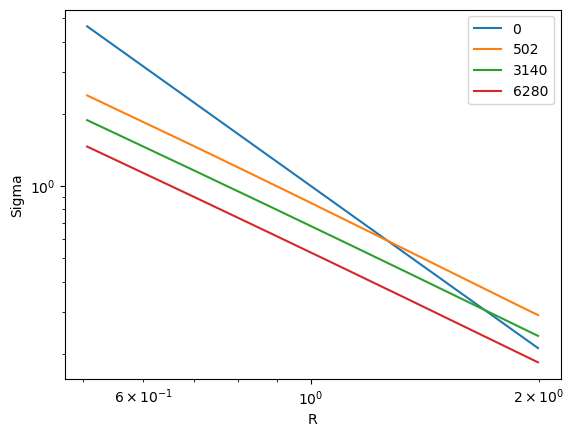

In [5]:
results_dir = "/scratch/phn2956/disk-sph1/"
#results_dir = "/scratch/phn2956/disk-cyl-alpha-BCs/"

hdf5_file0 = results_dir + "disk.out1.00000.athdf"
hdf5_file1 = results_dir + "disk.out1.00008.athdf"
hdf5_file2 = results_dir + "disk.out1.00050.athdf"
hdf5_file3 = results_dir + "disk.out1.00100.athdf"
#hdf5_file3 = "/scratch/phn2956/disk-cyl-BCs-only/disk.out1.00010.athdf"

file_list = [hdf5_file0, 
             hdf5_file1,
             hdf5_file2,
             hdf5_file3]

fig = plt.figure()
ax = fig.add_subplot()

for file in file_list:
    ath_data = athena_read.athdf(file,num_ghost=0,quantities=["dens", "mom1", "mom2", "mom3"])

    time = ath_data['Time']
    rad_app = ath_data['x1v']
    phi_app = ath_data['x2v']
    z_app = ath_data['x3v']
    
    rad_3d, phi_3d, z_3d = np.meshgrid(rad_app, phi_app, z_app, indexing='ij')
    
    #### Read Athena++ data: velosity field. ####
    px1 = np.swapaxes(ath_data['mom1'],0,2)
    px2 = np.swapaxes(ath_data['mom2'],0,2)
    px3 = np.swapaxes(ath_data['mom3'],0,2)
    dens10 = np.swapaxes(ath_data['dens'],0,2)
    
    px1 = np.swapaxes(ath_data['mom1'],0,2)
    dens = np.swapaxes(ath_data['dens'],0,2)

    dphi = phi_3d[0,1,0] - phi_3d[0,0,0]
    Sigma = np.sum(dens * dphi, axis=1) / (2 * np.pi)
    vR = np.sum(px1 / dens * dphi, axis=1) / (2*np.pi)

    slope = (np.log(Sigma[-1]) - np.log(Sigma[0])) / \
        (np.log(rad_app[-1]) - np.log(rad_app[0]))
    print("slope=", np.round(slope[0],2))

    ax.loglog(rad_app, Sigma[:,0], label=(int) (np.round(time,0)))


#plt.loglog(rad_app, .55*rad_app**(-3/2), label="power law")

plt.xlabel("R")
plt.ylabel("Sigma")

plt.legend()

## old

In [65]:

#ath_data = athena_read.athdf(hdf5_file,num_ghost=0,quantities=["rho", "vel1", "vel2", "vel3"])
ath_data0 = athena_read.athdf(hdf5_file0,num_ghost=0,quantities=["dens", "mom1", "mom2", "mom3"])
ath_data10 = athena_read.athdf(hdf5_file10,num_ghost=0,quantities=["dens", "mom1", "mom2", "mom3"])

# with h5py.File(file_path, "r") as f:
#     # Print all root level object names (aka keys) 
#     # these can be group or dataset names 
#     print("Keys: %s" % f.keys())
#     # get first object name/key; may or may NOT be a group
#     a_group_key = list(f.keys())[0]

#     # get the object type for a_group_key: usually group or dataset
#     print(type(f[a_group_key])) 

#     # If a_group_key is a group name, 
#     # this gets the object names in the group and returns as a list
#     data = list(f[a_group_key])

#     # If a_group_key is a dataset name, 
#     # this gets the dataset values and returns as a list
#     data = list(f[a_group_key])
#     # preferred methods to get dataset values:
#     ds_obj = f[a_group_key]      # returns as a h5py dataset object
#     ds_arr = f[a_group_key][()]  # returns as a numpy array

#     # cons = conserved variables (here, density and 3 components of momentum) 
#     conses = f['cons'][()] 
#     x1vs = f['x1v'][()] # cell-centered coordinates
#     x2vs = f['x2v'][()]
#     x3vs = f['x3v'][()]

# x1vs.shape

In [42]:
print(ath_data10['Time'])

6280.0


In [66]:
time = ath_data10['Time']
rad_app10 = ath_data10['x1v']
phi_app10 = ath_data10['x2v']
z_app10 = ath_data10['x3v']

rad_3d10, phi_3d10, z_3d10 = np.meshgrid(rad_app10, phi_app10, z_app10, indexing='ij')

#### Read Athena++ data: velosity field. ####
px1 = np.swapaxes(ath_data10['mom1'],0,2)
px2 = np.swapaxes(ath_data10['mom2'],0,2)
px3 = np.swapaxes(ath_data10['mom3'],0,2)
dens10 = np.swapaxes(ath_data10['dens'],0,2)

px1_0 = np.swapaxes(ath_data0['mom1'],0,2)
dens_0 = np.swapaxes(ath_data0['dens'],0,2)

In [38]:
px1.shape

(64, 64, 1)

[Example of a scatter plot on a polar grid](https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_scatter.html)

In [11]:
print(rad_3d.shape)
print(phi_3d.shape)
print(dens.shape)

(64, 64, 1)
(64, 64, 1)
(64, 64, 1)


In [67]:
dphi = phi_3d10[0,1,0] - phi_3d10[0,0,0]

Vr0 = np.sum(px1_0 / dens_0 * dphi, axis=1) / (2 * np.pi)
Vr10 = np.sum(px1 / dens10 * dphi, axis=1) / (2 * np.pi)

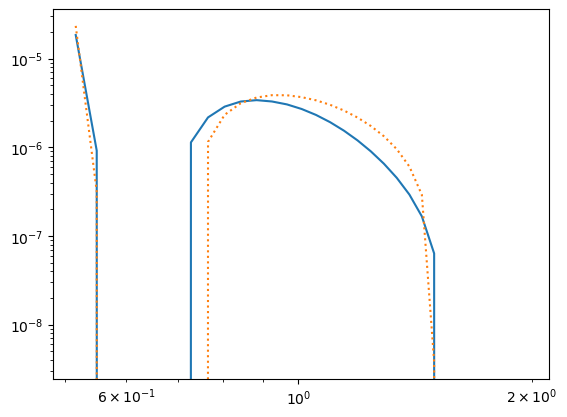

In [68]:
plt.loglog(rad_3d10[:,0,0], Vr0[:,0], linestyle="-")
plt.loglog(rad_3d10[:,0,0], Vr10[:,0], linestyle=":")

# plt.xlim(5e-1, 2)
# plt.ylim(.2, 6)

plt.show()

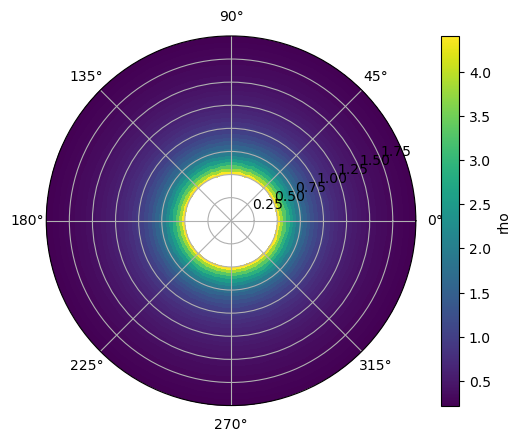

In [53]:
# Fixing random state for reproducibility
# np.random.seed(19680801)

# # Compute areas and colors
# N = 150
# r = 2 * np.random.rand(N)
# theta = 2 * np.pi * np.random.rand(N)
# area = 200 * r**2
# colors = theta

fig = plt.figure()
#ax = fig.add_subplot()
ax = fig.add_subplot(projection='polar')
#c = ax.scatter(theta, r, c=colors, cmap='viridis', alpha=0.75)
# c = ax.scatter(phi_3d, rad_3d, c=dens, cmap='viridis', alpha=0.75)

c = ax.pcolormesh(phi_3d10[:,:,0], rad_3d10[:,:,0], dens10[:,:,0], cmap='viridis')

# ax = fig.add_subplot()
# ax.pcolormesh(thetas, rs, rhos.T)

fig.colorbar(c, ax=ax, label="rho")

save_fig = False
if save_fig:
    plt.savefig("Figs/disk-rho100.png")

plt.show()